# Fitting Logistic Growth Curves

---

## Background

In this tutorial we will cover how to fit growth curves on data from PhenoTypic. For growth curves you'll typically want to use metrics of size from `pht.measure.MeasureSize`: "Size_Area" or "Size_IntegratedIntensity". These can also be obtained from `pht.measure.MeasureArea` or `pht.measure.MeasureIntensity` respectively.

Size Metric Comparison:
| Metric                          | Pros                                         | Cons |
|:--------------------------------|:---------------------------------------------|:-----|
| "Shape_Area"                    | Simple to set up<br> Captures lateral growth | Misses Vertical Growth |
| "Intensity_IntegratedIntensity" | Captures lateral and vertical growth         | Requires color correction if there's significant color drift or lots of color variation between colonies |


Phenotypic uses the following form of the logistic formula:

$N(t) = \frac{K } {1 + \frac{K - N0}{N0}  e^{-r t}}$

Which is fitted using the following loss function
 Loss Function Calculation:

$J(K,N_0,r) = \frac{1}{n}\sum_{i=1}^{n}\frac{1}{2}(f_{K,N0,r}(t^{(i)}) - N_t^{(i)})^2)
+ \lambda(\frac{dN}{dt}^2 + N_0^2)
+ \alpha \frac{\lvert K-\max({N_t})\rvert}{N_t}$

$N_t$: population size at time t

$N_0$: initial population size at time t

$r$: growth rate

$K$: Carrying capacity (maximum population size).

$\lambda$: regularization term for growth rate and initial population size

$\alpha$: penalty term for deviations in the carrying capacity relative to the largest measurement

The data in this tutorial comes from the {doc} `QuickStart` tutorial

In this tutorial we use the following:
- `pht.analysis.LogGrowthModel`


In [ ]:
import phenotypic as pht

meas = pht.data.load_quickstart_meas()

# Lets isolate the measurements we care about
meas = (meas[["Metadata_ImageName", "Grid_SectionNum", "Metadata_Media", "Metadata_StrainName", "Metadata_Time",
              "Shape_Area"]]
        .sort_values(by=['Metadata_StrainName', "Metadata_Time"]))

meas["Metadata_Time"] = meas["Metadata_Time"].astype(int)  # Ensures that the time column is numeric
meas.head(10)

In automated image processing, depending on the scene, objects can be:
- oversegmented (some of the background is detected along with the object)
- undersegmented (some of the object is not detected with the object)
- noise that was detected as an object

Other factors that may mess with our growth curves include stochastic biological noise or experimental error as well. To refine the data to reflect the true growth kinetics better, we can apply tukey's outlier on the dataset.

In [2]:
from phenotypic.analysis import TukeyOutlierRemover

tukey_outlier_analysis = TukeyOutlierRemover(
        on="Shape_Area",
        groupby=["Metadata_StrainName", "Metadata_Time"]
)

tukey_results = tukey_outlier_analysis.analyze(meas)

tukey_results

,Metadata_ImageName,Grid_SectionNum,Metadata_Media,Metadata_StrainName,Metadata_Time,Shape_Area
0,2_1S_5,0,S,SYNTH-00,2,2296.0
1,2_1S_6,0,S,SYNTH-00,2,2419.0
2,2_1S_7,0,S,SYNTH-00,2,2752.0
3,3_1S_5,0,S,SYNTH-00,3,2676.0
4,3_1S_6,0,S,SYNTH-00,3,2879.0
...,...,...,...,...,...,...
1660,5_1S_7,95,S,SYNTH-95,5,3702.0
1661,5_1S_8,95,S,SYNTH-95,5,3602.0
1662,6_1S_5,95,S,SYNTH-95,6,4054.0
1663,6_1S_6,95,S,SYNTH-95,6,4148.0


(<Figure size 1000x1200 with 1 Axes>,
 <Axes: xlabel='Shape_Area', ylabel='Group'>)

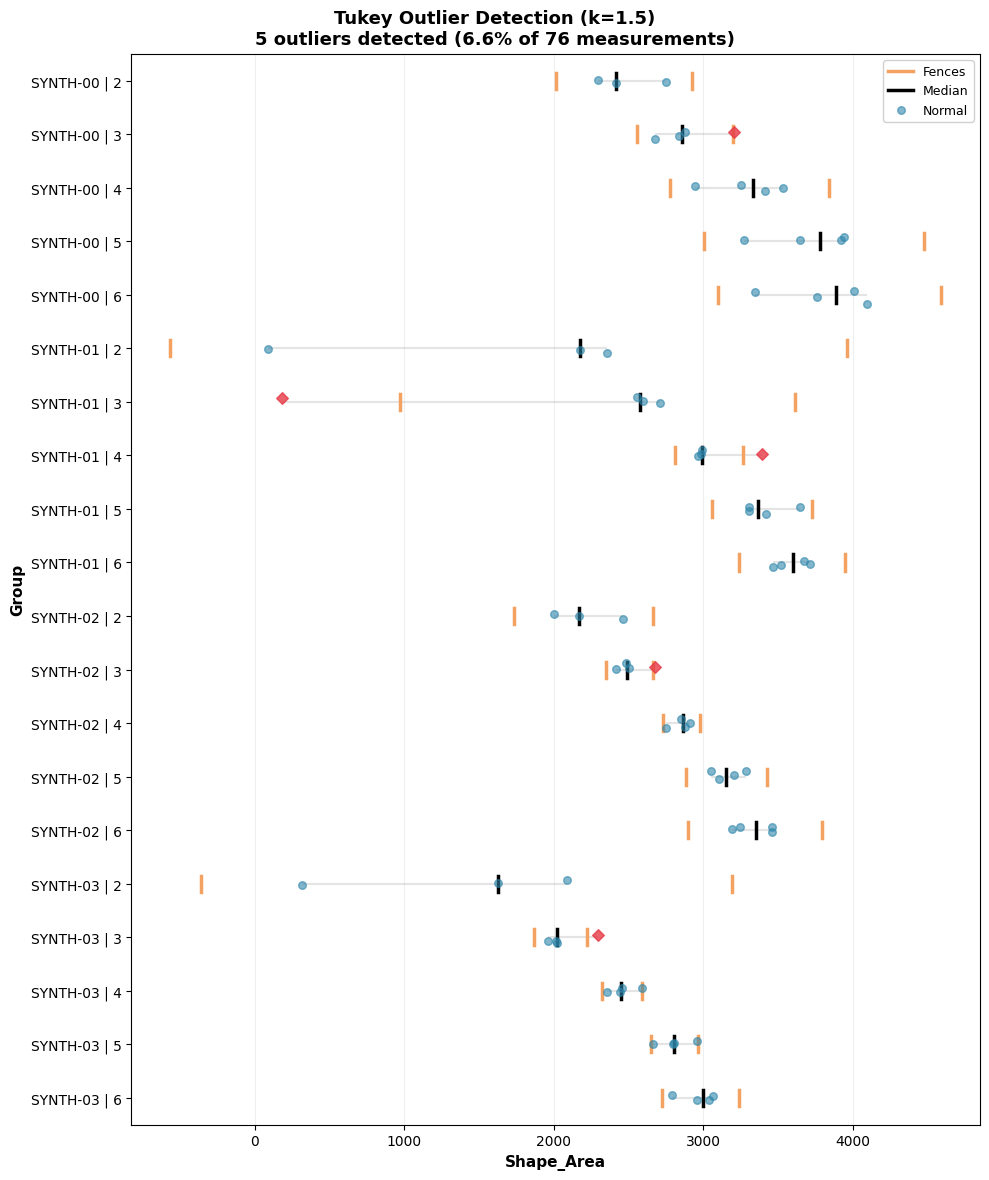

In [3]:
tukey_outlier_analysis.show(collapsed=True)

## Fit model

In [4]:
log_model = pht.analysis.LogGrowthModel(on='Shape_Area', groupby=['Metadata_StrainName'],
                                        agg_func='mean',
                                        time_label='Metadata_Time',
                                        lam=0.5,
                                        alpha=2.0,
                                        n_jobs=-1)
model_fit = log_model.analyze(meas)
model_fit.head()

,Metadata_StrainName,LogGrowthModel_r,LogGrowthModel_K,LogGrowthModel_N0,LogGrowthModel_d(N)/dt,LogGrowthModel_Kmax,LogGrowthModel_NumSamples,LogGrowthModel_OptimizerLoss,LogGrowthModel_OptimizerStatus,LogGrowthModel_MAE,LogGrowthModel_MSE,LogGrowthModel_RMSE
0,SYNTH-00,0.883466,3803.75000,730.656267,840.121357,3803.75,5,359605.854680,2,112.909778,19876.094460,140.982603
1,SYNTH-01,0.897963,3593.00000,362.728324,806.595365,3593.00,5,267796.348493,2,162.670026,28901.747357,170.005139
2,SYNTH-02,0.861219,3323.12414,663.646007,715.484302,3341.25,5,285156.211098,2,100.930425,18828.103607,137.215537
3,SYNTH-03,0.888562,2963.00000,371.361178,658.202340,2963.00,5,153196.833795,2,54.081231,4164.789012,64.535177
4,SYNTH-04,0.885977,3031.75000,593.237551,671.515563,3031.75,5,236796.306351,2,94.777279,14432.128153,120.133793


Parameters:
- `on`: What column to measure on
- `groupby`: What columns to form groups on. See also: `pandas.DataFrame.groupby()`
- `agg_func`: How to aggregate replicate time points. Default is "mean". For other options see: `pandas.DataFrame.agg()`
- `time_label`: What column is to use for the time measurement. This should be added by the user either as metadata or externally.
- `lam`: The regularization factor for specific growth rate

## Display results

(<Figure size 600x400 with 1 Axes>, <Axes: title={'center': 'mean±SE'}>)

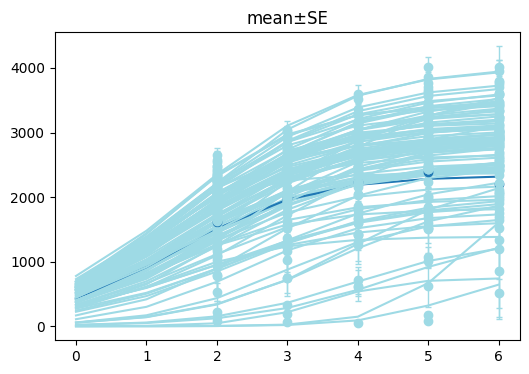

In [5]:
log_model.show()

ValueError: arange: cannot compute length

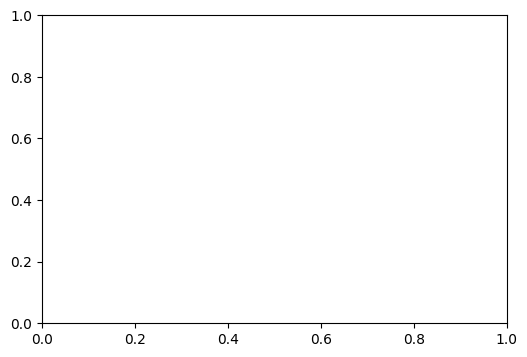

In [6]:
log_model.show(criteria={'Metadata_StrainName': ['CBS11445']})

If we want to display only one of the strains, we can use the criteria like above. You can specify which column you want to filter by as a key and provide the